In [1]:
#import necessary libraries

import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

project_name='05b-cifar10-resnet'

In [2]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
'''
Its important to resize the image here to a size suitable with the model depth,
so here anything equals or above 112x112 will work fine, but the original size (32x32) needs a simpler model.
Also AutoAugment is very useful here for better stability during training 
as he automatically determine the best augmentation techniques used for this data.
'''
train_tfms = tt.Compose([tt.Resize((112,112)),
                         tt.AutoAugment(policy=tt.AutoAugmentPolicy.CIFAR10),
                         tt.ToTensor(),
                         tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose([tt.Resize((112,112)),tt.ToTensor(),tt.Normalize(*stats)])

In [3]:
# Reading CIFAR-10 dataset
data_path = "./"
train_ds = torchvision.datasets.CIFAR10(data_path,
                                             train=True,
                                             transform=train_tfms,
                                             download=True)

valid_ds = torchvision.datasets.CIFAR10(data_path,
                                            train=False,
                                            transform=valid_tfms)

100%|██████████| 170498071/170498071 [00:12<00:00, 14134154.50it/s]


Extracting ./cifar-10-python.tar.gz to ./


In [7]:
num_gpus = torch.cuda.device_count()
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)
# train_valid_dataloader = torch.utils.data.DataLoader(train_valid_dataset, batch_size=128, shuffle=True, num_workers=2*num_gpus, pin_memory=True)

valid_dataloader = torch.utils.data.DataLoader(valid_ds, batch_size=512, shuffle=False, num_workers=2*num_gpus, pin_memory=True)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2*num_gpus, pin_memory=True)

In [8]:
# using a bigger batch size here will work better as each class has around 6000 img.
batch_size=512
# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size, num_workers=3, pin_memory=True)

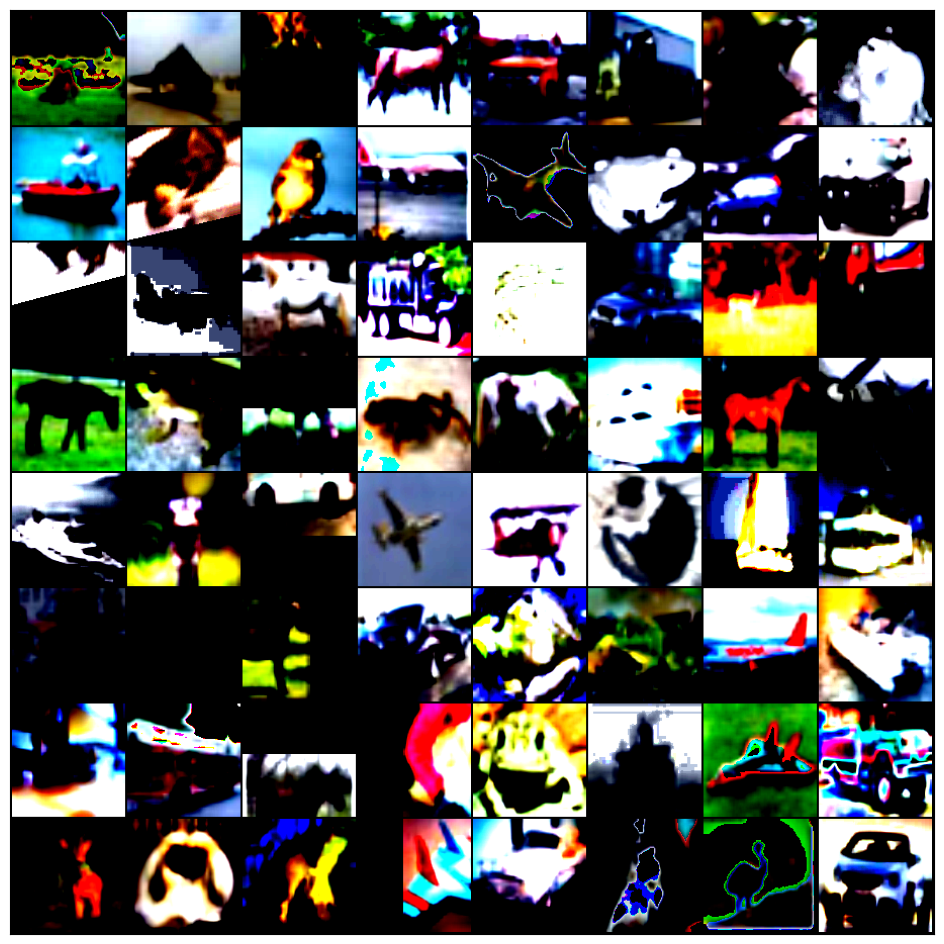

In [9]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break
        
show_batch(train_dl)

In [10]:
#To seamlessly use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and
#a helper class DeviceDataLoader to move our model & data to the GPU as required.

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    def __len__(self):
        """Number of batches"""
        return len(self.dl)
    

In [11]:
device = get_default_device()
device

device(type='cuda')

In [12]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [35]:
def get_net():
    # here we are improting built-in resnet34 pre-trained on imagenet for better performance & faster convergence.
    resnet = torchvision.models.resnet18(pretrained=True)
    
    # Substitute the FC output layer
    # we replace the last fully connected layer to be only connected to 10 neurons instead of 1000 because we are working only on 10 classes.
    # we also add one fully connected layer before the output layer
    
    fc_layers=[]
    fc_layers.extend([nn.Linear(resnet.fc.in_features,256),
                     nn.ReLU(inplace=True),
                     nn.Dropout(p=0.5),
                     nn.Linear(256,10)])
    
    resnet.fc = nn.Sequential(*fc_layers)

    return resnet

In [36]:
import time

def train(net, train_dataloader, valid_dataloader, criterion, optimizer, scheduler=None, epochs=10, device='cpu', checkpoint_epochs=10):
    start = time.time()
    print(f'Training for {epochs} epochs on {device}')

    for epoch in range(1,epochs+1):
        print(f"Epoch {epoch}/{epochs}")

        net.train()  # put network in train mode for Dropout and Batch Normalization
        train_loss = torch.tensor(0., device=device)  # loss and accuracy tensors are on the GPU to avoid data transfers
        train_accuracy = torch.tensor(0., device=device)
        for X, y in train_dataloader:
            X = X.to(device)
            y = y.to(device)
            preds = net(X)
            loss = criterion(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                train_loss += loss * train_dataloader.batch_size
                train_accuracy += (torch.argmax(preds, dim=1) == y).sum()

        if valid_dataloader is not None:
            net.eval()  # put network in train mode for Dropout and Batch Normalization
            valid_loss = torch.tensor(0., device=device)
            valid_accuracy = torch.tensor(0., device=device)
            with torch.no_grad():
                for X, y in valid_dataloader:
                    X = X.to(device)
                    y = y.to(device)
                    preds = net(X)
                    loss = criterion(preds, y)

                    valid_loss += loss * valid_dataloader.batch_size
                    valid_accuracy += (torch.argmax(preds, dim=1) == y).sum()

        if scheduler is not None:
            #scheduler.step()
            scheduler.step(epoch)

        print(f'Training loss: {train_loss/len(train_dataloader.dataset):.2f}')
        print(f'Training accuracy: {100*train_accuracy/len(train_dataloader.dataset):.2f}')

        if valid_dataloader is not None:
            print(f'Valid loss: {valid_loss/len(valid_dataloader.dataset):.2f}')
            print(f'Valid accuracy: {100*valid_accuracy/len(valid_dataloader.dataset):.2f}')

        if epoch%checkpoint_epochs==0:
            torch.save({
                'epoch': epoch,
                'state_dict': net.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, './checkpoint.pth.tar')

        print()

    end = time.time()
    print(f'Total training time: {end-start:.1f} seconds')
    return net


## SGD optimizer¶

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr, weight_decay, epochs = 1e-4, 5e-4, 10

net = get_net().to(device)

# Standard CrossEntropy Loss for multi-class classification problems

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

net = train(net, train_dataloader, valid_dataloader, criterion, optimizer, scheduler, epochs, device)

Training for 10 epochs on cuda
Epoch 1/10
Training loss: 0.94
Training accuracy: 68.36
Valid loss: 0.30
Valid accuracy: 90.13

Epoch 2/10
Training loss: 0.37
Training accuracy: 87.04
Valid loss: 0.26
Valid accuracy: 91.24

Epoch 3/10
Training loss: 0.29
Training accuracy: 90.15
Valid loss: 0.21
Valid accuracy: 92.85

Epoch 4/10
Training loss: 0.24
Training accuracy: 91.74
Valid loss: 0.22
Valid accuracy: 92.46

Epoch 5/10
Training loss: 0.21
Training accuracy: 92.97
Valid loss: 0.23
Valid accuracy: 92.68

Epoch 6/10
Training loss: 0.19
Training accuracy: 93.41
Valid loss: 0.20
Valid accuracy: 93.76

Epoch 7/10
Training loss: 0.17
Training accuracy: 94.35
Valid loss: 0.19
Valid accuracy: 93.78

Epoch 8/10
Training loss: 0.16
Training accuracy: 94.60
Valid loss: 0.22
Valid accuracy: 93.37

Epoch 9/10
Training loss: 0.15
Training accuracy: 94.93
Valid loss: 0.19
Valid accuracy: 94.27

Epoch 10/10
Training loss: 0.14
Training accuracy: 95.36
Valid loss: 0.20
Valid accuracy: 93.87

Total tr

## Adam Optimizer

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr, weight_decay, epochs = 1e-4, 5e-4, 10

net = get_net().to(device)

# Standard CrossEntropy Loss for multi-class classification problems
criterion = torch.nn.CrossEntropyLoss()

# params_1x are the parameters of the network body, i.e., of all layers except the FC layers
params_1x = [param for name, param in net.named_parameters() if 'fc' not in str(name)]
optimizer = torch.optim.Adam([{'params':params_1x}, {'params': net.fc.parameters(), 'lr': lr}], lr=lr, weight_decay=weight_decay)

net = train(net, train_dataloader, valid_dataloader, criterion, optimizer, None, epochs, device)

Training for 10 epochs on cuda
Epoch 1/10
Training loss: 0.83
Training accuracy: 74.54
Valid loss: 0.28
Valid accuracy: 91.06

Epoch 2/10
Training loss: 0.34
Training accuracy: 88.42
Valid loss: 0.21
Valid accuracy: 93.06

Epoch 3/10
Training loss: 0.25
Training accuracy: 91.77
Valid loss: 0.19
Valid accuracy: 93.55

Epoch 4/10
Training loss: 0.21
Training accuracy: 93.16
Valid loss: 0.20
Valid accuracy: 93.72

Epoch 5/10
Training loss: 0.18
Training accuracy: 94.10
Valid loss: 0.19
Valid accuracy: 94.08

Epoch 6/10
Training loss: 0.15
Training accuracy: 94.76
Valid loss: 0.18
Valid accuracy: 94.46

Epoch 7/10
Training loss: 0.14
Training accuracy: 95.23
Valid loss: 0.20
Valid accuracy: 94.05

Epoch 8/10
Training loss: 0.14
Training accuracy: 95.40
Valid loss: 0.19
Valid accuracy: 94.04

Epoch 9/10
Training loss: 0.13
Training accuracy: 95.63
Valid loss: 0.19
Valid accuracy: 94.20

Epoch 10/10
Training loss: 0.12
Training accuracy: 95.88
Valid loss: 0.19
Valid accuracy: 94.32

Total tr

## AdamW

In [26]:
!pip install timm

In [37]:
import timm
from timm.scheduler.cosine_lr import CosineLRScheduler
from timm.scheduler import create_scheduler
from timm.optim import create_optimizer
import argparse
parser = argparse.ArgumentParser(
        'training and evaluation script', add_help=False)


# Optimizer parameters
parser.add_argument('--opt', default='adamw', type=str, metavar='OPTIMIZER',
                    help='Optimizer (default: "adamw"')
parser.add_argument('--opt-eps', default=1e-8, type=float, metavar='EPSILON',
                    help='Optimizer Epsilon (default: 1e-8)')
parser.add_argument('--opt-betas', default=None, type=float, nargs='+', metavar='BETA',
                    help='Optimizer Betas (default: None, use opt default)')
parser.add_argument('--clip-grad', type=float, default=None, metavar='NORM',
                    help='Clip gradient norm (default: None, no clipping)')
parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                    help='SGD momentum (default: 0.9)')
parser.add_argument('--weight-decay', type=float, default=0.05,
                    help='weight decay (default: 0.05)')


    # Learning rate schedule parameters
parser.add_argument('--sched', default='cosine', type=str, metavar='SCHEDULER',
                    help='LR scheduler (default: "cosine"')
parser.add_argument('--lr', type=float, default=8e-5, metavar='LR',  #2e-3  #5e-4
                    help='learning rate (default: 5e-4)')
parser.add_argument('--lr-noise', type=float, nargs='+', default=None, metavar='pct, pct',
                    help='learning rate noise on/off epoch percentages')
parser.add_argument('--lr-noise-pct', type=float, default=0.67, metavar='PERCENT',
                    help='learning rate noise limit percent (default: 0.67)')
parser.add_argument('--lr-noise-std', type=float, default=1.0, metavar='STDDEV',
                    help='learning rate noise std-dev (default: 1.0)')
parser.add_argument('--warmup-lr', type=float, default=1e-5, metavar='LR',   # 1e-6
                    help='warmup learning rate (default: 1e-6)')
parser.add_argument('--min-lr', type=float, default=2e-5, metavar='LR',     #1e-5
                    help='lower lr bound for cyclic schedulers that hit 0 (1e-5)')

parser.add_argument('--decay-epochs', type=float, default=30, metavar='N',
                    help='epoch interval to decay LR')
parser.add_argument('--warmup-epochs', type=int, default=5, metavar='N',        # 5
                    help='epochs to warmup LR, if scheduler supports')
parser.add_argument('--cooldown-epochs', type=int, default=10, metavar='N',
                    help='epochs to cooldown LR at min_lr, after cyclic schedule ends')
parser.add_argument('--patience-epochs', type=int, default=10, metavar='N',
                    help='patience epochs for Plateau LR scheduler (default: 10')
parser.add_argument('--decay-rate', '--dr', type=float, default=0.1, metavar='RATE',
                    help='LR decay rate (default: 0.1)')

args,unknown = parser.parse_known_args()

criterion = torch.nn.CrossEntropyLoss()

net = get_net().to(device)
optimizer = create_optimizer(args,net)
cosine_lr_scheduler, _ = create_scheduler(args, optimizer)

In [38]:
net = train(net, train_dataloader, valid_dataloader, criterion, optimizer, cosine_lr_scheduler, 12, device)

Training for 12 epochs on cuda
Epoch 1/12
Training loss: 2.09
Training accuracy: 27.66
Valid loss: 1.53
Valid accuracy: 66.56

Epoch 2/12
Training loss: 1.16
Training accuracy: 65.79
Valid loss: 0.53
Valid accuracy: 85.31

Epoch 3/12
Training loss: 0.59
Training accuracy: 81.32
Valid loss: 0.30
Valid accuracy: 90.75

Epoch 4/12
Training loss: 0.42
Training accuracy: 86.27
Valid loss: 0.24
Valid accuracy: 92.12

Epoch 5/12
Training loss: 0.33
Training accuracy: 89.29
Valid loss: 0.21
Valid accuracy: 93.22

Epoch 6/12
Training loss: 0.28
Training accuracy: 90.79
Valid loss: 0.20
Valid accuracy: 93.53

Epoch 7/12
Training loss: 0.23
Training accuracy: 92.27
Valid loss: 0.20
Valid accuracy: 93.59

Epoch 8/12
Training loss: 0.20
Training accuracy: 93.42
Valid loss: 0.19
Valid accuracy: 93.97

Epoch 9/12
Training loss: 0.18
Training accuracy: 94.17
Valid loss: 0.19
Valid accuracy: 94.20

Epoch 10/12
Training loss: 0.17
Training accuracy: 94.57
Valid loss: 0.20
Valid accuracy: 94.13

Epoch 11